In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.cifar10 import load_data

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [17]:
#load data
(x_train, y_train), (x_test, y_test) = load_data()

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

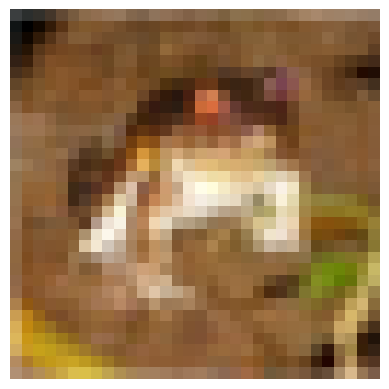

In [19]:
plt.imshow(x_train[0])
plt.axis('off')
plt.show()

In [20]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

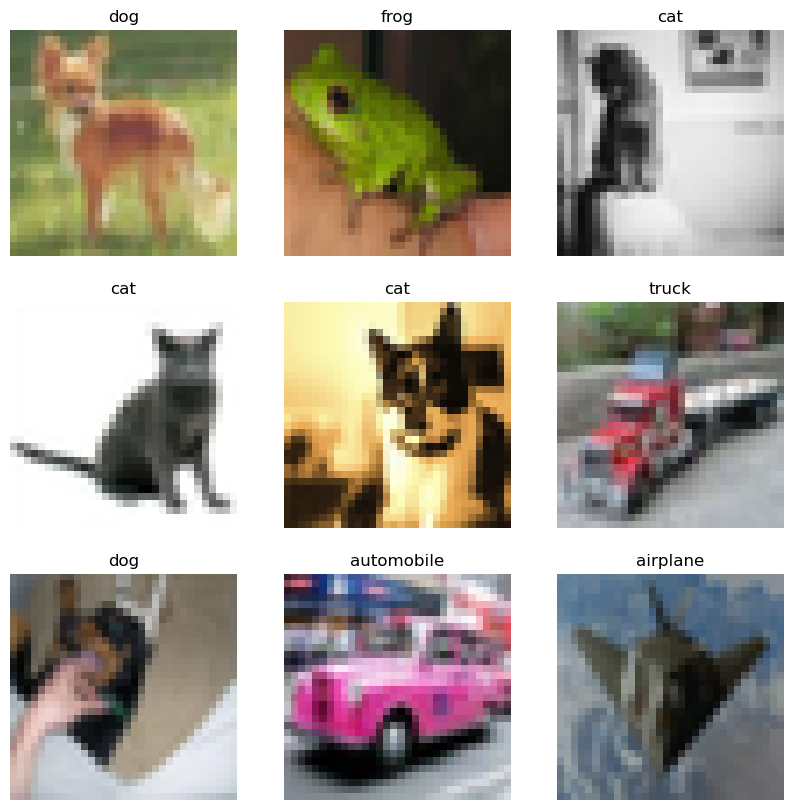

In [22]:
plt.figure(figsize=(10, 10))

for i in range(9):
  random_index = np.random.randint(0, 50000)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[random_index].astype("uint8"))  # display the image
  plt.title(class_names[y_train[random_index][0]])  # extract the class name from the label
  plt.axis("off")

In [23]:
# #normalize data
x_train = x_train / 255.
x_test = x_test / 255.

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64

# convert the data to use the .cache() method to cache datasets in memory for better performance
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train = (
    train
    .shuffle(1000)
    .batch(batch_size)
    .cache()
    .prefetch(AUTOTUNE)
)

test = (
    test
    .batch(batch_size)
    .cache()
    .prefetch(AUTOTUNE)
)

In [25]:
data_preprocessing = Sequential([
    tf.keras.layers.Resizing(32, 32),
    tf.keras.layers.Rescaling(1./255)
])

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomTranslation(0.1, 0.1), 
  tf.keras.layers.RandomContrast(0.1),
  tf.keras.layers.RandomZoom(0.1)
])

## Simple model based on previous hyperparameter tuning

In [31]:
# kernel_reg = 0.01
model = Sequential([
    data_preprocessing,
    data_augmentation,

    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',# kernel_regularizer=l2(kernel_reg),
           input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),# kernel_regularizer=l2(kernel_reg)),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),# kernel_regularizer=l2(kernel_reg)),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    Flatten(),

    # Dense(units=4096, activation='relu'),
    # Dropout(0.3),
    Dense(units=2024, activation='relu'),
    Dropout(0.2),
    Dense(units=1024, activation='relu'),
    Dropout(0.2),
    Dense(units=512, activation='relu'),
    Dropout(0.2),
    Dense(units=10, activation='softmax')
])



In [32]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [29]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    # ModelCheckpoint(filepath='/hypermodel/hypermodel_V2-{epoch}.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

In [33]:
history = model.fit(train, epochs=50, verbose=1,
                     validation_data=test,
                     callbacks=callbacks)

Epoch 1/50
782/782 [==============================] - 253s 319ms/step - loss: 1.6249 - accuracy: 0.4223 - val_loss: 1.8618 - val_accuracy: 0.3033 - lr: 0.0010
Epoch 2/50
782/782 [==============================] - 241s 309ms/step - loss: 1.3394 - accuracy: 0.5291 - val_loss: 1.9825 - val_accuracy: 0.3911 - lr: 0.0010
Epoch 3/50
782/782 [==============================] - 230s 294ms/step - loss: 1.2236 - accuracy: 0.5747 - val_loss: 4.1093 - val_accuracy: 0.2107 - lr: 0.0010
Epoch 4/50
782/782 [==============================] - 219s 280ms/step - loss: 1.1487 - accuracy: 0.6063 - val_loss: 3.3659 - val_accuracy: 0.2593 - lr: 0.0010
Epoch 5/50
782/782 [==============================] - 228s 292ms/step - loss: 0.9808 - accuracy: 0.6613 - val_loss: 1.1597 - val_accuracy: 0.6065 - lr: 1.0000e-04
Epoch 6/50
782/782 [==============================] - 227s 291ms/step - loss: 0.9215 - accuracy: 0.6802 - val_loss: 0.9744 - val_accuracy: 0.6656 - lr: 1.0000e-04
Epoch 7/50
782/782 [==================

In [ ]:
eval_result = model.evaluate(x_test, y_test)

# Print the test loss and test accuracy
print("[test loss, test accuracy]:", eval_result)

Saving the model

In [ ]:
# Save the tuned model for future reference
hypermodel.save('../Models/hypertuned-cifar-cnn-model.keras')

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('/hypermodel/accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('/hypermodel/loss.png')
plt.show()